In [1]:
import LanusStats as ls
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects 
import numpy as np
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import Divider
from mplsoccer import PyPizza
import textwrap as tw
from PIL import Image

In [2]:
fbref = ls.Fbref()

In [3]:
df = fbref.get_all_player_season_stats('Copa de la Liga', '2024')

stats
Starting to scrape player data from Fbref...
keepers
Starting to scrape player data from Fbref...
keepersadv
Starting to scrape player data from Fbref...
shooting
Starting to scrape player data from Fbref...
passing
Starting to scrape player data from Fbref...
passing_types
Starting to scrape player data from Fbref...
gca
Starting to scrape player data from Fbref...
defense
Starting to scrape player data from Fbref...
possession
Starting to scrape player data from Fbref...
playingtime
Starting to scrape player data from Fbref...
misc
Starting to scrape player data from Fbref...


In [101]:
playerinfo_df = df[0]
playerinfo_df['name'] = playerinfo_df['Player']

In [90]:
playerinfo_df.head(2)

,Player,stats_Nation,stats_Pos,stats_Squad,stats_Comp,stats_Age,stats_Born,stats_MP,stats_Starts,stats_Min,...,misc_PKwon,misc_PKcon,misc_OG,misc_Recov,misc_Won,misc_Lost,misc_Won%,Primary Player,name,Plot Size
22,Marcelino Moreno,ar ARG,"MF,FW",Lanús,Copa de la Liga,29,1994,14,14,"1,133",...,0,0,0,69.0,4,11,26.7,Primary 1,Marcelino Moreno,7
0,Kevin Zenon,ar ARG,MF,Boca Juniors,Copa de la Liga,22,2001,14,13,"1,189",...,0,0,0,83.0,8,9,47.1,Untagged,Kevin Zenon,7


In [67]:
playerinfo_df['stats_90s'].astype(float).describe()

count    390.000000
mean       4.862821
std        3.910960
min        0.000000
25%        1.425000
50%        3.950000
75%        7.700000
max       14.000000
Name: stats_90s, dtype: float64

In [99]:
player_1 = {'name':'Facundo Mura', 'comp':'Copa de la Liga', 'year':'2024'}
#player_2 = {'name':'Oliver Norwood', 'comp':'EFLC', 'year':'2022'}
comparison_competition = {'comp':'Copa de la Liga', 'year':'2024', 'position': 'DF', '90s': 6}
comparison_logo_brighten = True
player_1_colour = 'lightskyblue'
#player_2_colour = 'coral'

In [95]:
playerinfo_df[playerinfo_df['name'] == player_1['name']]['stats_Squad'].iloc[0]

'Lanus'

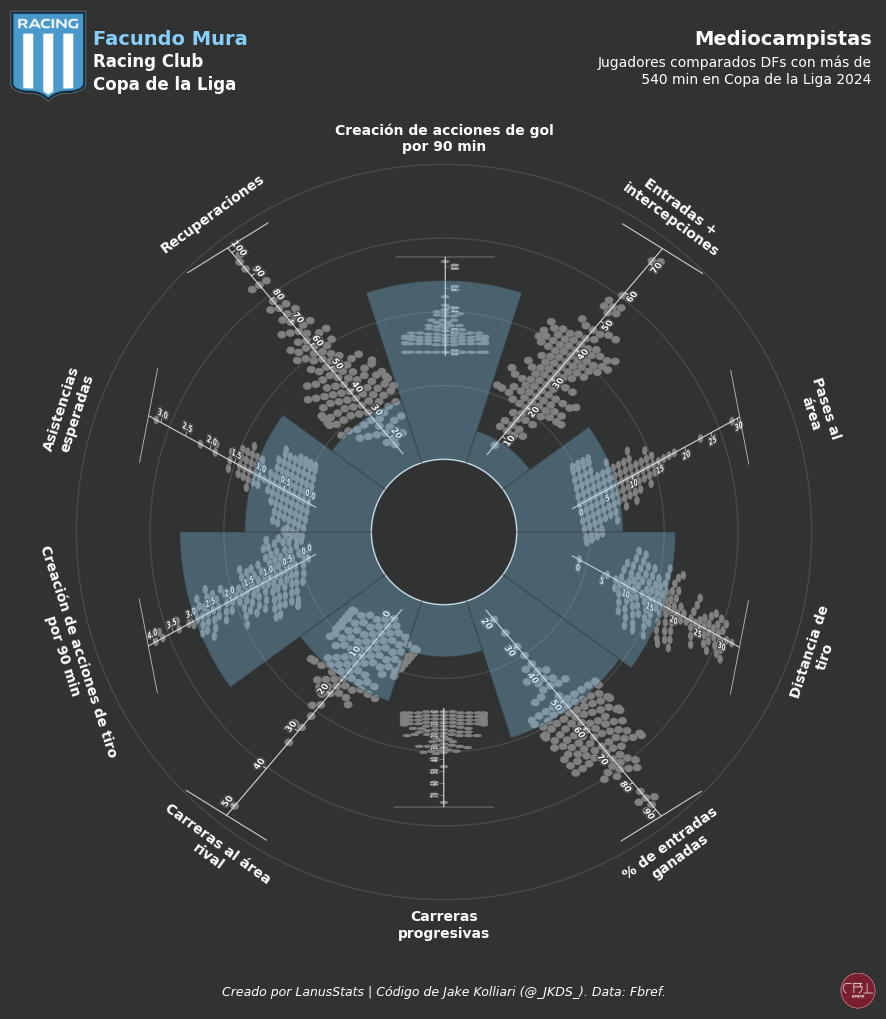

In [102]:
# %% Templates 

template = 'Mediocampistas'
swarm_radar_metrics = ['gca_GCA90',
                       'misc_Recov',
                       'passing_xA',
                       'gca_SCA90',
                       'possession_Att Pen',
                       'possession_PrgC',
                       'defense_Tkl%',
                       'shooting_Dist',
                       'passing_PPA',
                       'defense_Tkl+Int']
swarm_radar_titles = ['Creación de acciones de gol\npor 90 min',
                      'Recuperaciones',
                      'Asistencias\nesperadas',
                      'Creación de acciones de tiro\npor 90 min',
                      'Carreras al área\nrival',
                      'Carreras\nprogresivas',
                      '% de entradas\nganadas',
                      'Distancia de\ntiro',
                      'Pases al\nárea',
                      'Entradas +\nintercepciones']
neg_metrics = ''

# %% Generate swarm radar

path_eff = [path_effects.Stroke(linewidth=2, foreground='#313332'), path_effects.Normal()]
playerinfo_df = df[0]
playerinfo_df['name'] = playerinfo_df['Player']
# Tag primary players
playerinfo_df['Primary Player'] = 'Untagged'
if player_1['name'] != '':
    player_1_id = playerinfo_df[(playerinfo_df['name'] == player_1['name']) & (playerinfo_df['stats_Comp'] == player_1['comp'])].index.values[0]
    playerinfo_df.loc[player_1_id, 'Primary Player'] = 'Primary 1'
#if player_2['name'] != '':
#    player_2_id = playerinfo_df[(playerinfo_df['name'] == player_2['name']) & (playerinfo_df['stats_Comp'] == player_2['comp'])].index.values[0]
#    playerinfo_df.loc[player_2_id, 'Primary Player'] = 'Primary 2'

playerinfo_df['Plot Size'] = playerinfo_df['Primary Player'].apply(lambda x: 7 if x == 'Untagged' else 7)

playerinfo_df['stats_Squad'] = playerinfo_df['stats_Squad'].replace({
    'Lanús': 'Lanus'
})

# Sort dataframe to highlight tagged players
playerinfo_df = playerinfo_df.sort_values('Primary Player')
playerinfo_df['stats_90s'] = playerinfo_df['stats_90s'].astype(float)
playerinfo_df = playerinfo_df[(playerinfo_df['stats_Pos'].str.contains(comparison_competition['position'])) & (playerinfo_df['stats_90s'] >= comparison_competition['90s'])]

# Number of metrics
num_metrics = len(swarm_radar_metrics)

# Define the position and size of the child axes (in polar coordinates)
theta_mid = np.radians(np.linspace(0, 360, num_metrics+1))[:-1]+np.pi/2
theta_mid = [x if x <2*np.pi else x-2*np.pi for x in theta_mid]
theta_base = theta_mid-np.mean(np.diff(theta_mid))/2
theta_delta = np.mean(np.diff(theta_mid))
r_base = np.linspace(0.25, 0.25, num_metrics+1)[:-1]

# Convert to x,y coordinates
x_base, y_base = 0.325 + r_base * np.cos(theta_mid), 0.3 + 0.89 * r_base * np.sin(theta_mid)

# Create large figure
fig = plt.figure(constrained_layout=False, figsize = (9, 10.2))
fig.set_facecolor('#313332')

# Setup radar axis and object
theta = np.arange(0, 2*np.pi, 0.01)
radar_ax = fig.add_axes([0.025, 0, 0.95, 0.95],polar=True)
radar_ax.plot(theta, theta*0 + 0.17, color = 'w', lw = 1)
radar_ax.plot(theta, theta*0 + 0.3425, color = 'grey', lw = 1, alpha = 0.3)
radar_ax.plot(theta, theta*0 + 0.5150, color = 'grey', lw = 1, alpha = 0.3)
radar_ax.plot(theta, theta*0 + 0.6875, color = 'grey', lw = 1, alpha = 0.3)
radar_ax.plot(theta, theta*0 + 0.86, color = 'grey', lw = 1, alpha = 0.3)
radar_ax.axis('off')

# Store ax limits
ax_mins = []
ax_maxs = []

# Iterate through each metric 
for idx, metric in enumerate(swarm_radar_metrics):

    # Create mini figure
    fig_save, ax_save = plt.subplots(figsize = (4.5, 1.5))
    fig_save.set_facecolor('#313332')
    fig_save.patch.set_alpha(0)
    playerinfo_df[metric] = playerinfo_df[metric].astype(float)
    # Plot on axis
    sns.swarmplot(x=playerinfo_df[metric], y=[""]*len(playerinfo_df), color='grey', edgecolor='w', s=playerinfo_df['Plot Size'], zorder=1)
    ax_save.legend([],[], frameon=False)
    ax_save.patch.set_alpha(0)
    ax_save.spines['bottom'].set_position(('axes', 0.5))
    ax_save.spines['bottom'].set_color('w')
    ax_save.spines['top'].set_color(None)
    ax_save.spines['right'].set_color('w')
    ax_save.spines['left'].set_color(None)
    ax_save.set_xlabel("")
    ax_save.tick_params(left=False, bottom=True)
    ax_save.tick_params(axis='both', which='major', labelsize=8, zorder=10, pad = 0, colors = 'w')
    if theta_mid[idx] < np.pi/2 or theta_mid[idx] > 3*np.pi/2:
        plt.xticks(path_effects=path_eff, fontweight = 'bold')
    else:
        plt.xticks(path_effects=path_eff, fontweight = 'bold', rotation = 180)

    if metric in neg_metrics:
        ax_save.invert_xaxis()
    ax_mins.append(ax_save.get_xlim()[0])
    ax_maxs.append(ax_save.get_xlim()[1]*1.05)

    fig_save.savefig('temp.png', dpi=300)
    
    # Define axis scale
    scales = (0, 1, 0, 1)

    # Add scale and rotation transformations
    t = Affine2D().scale(3,1).rotate_deg(theta_mid[idx]*(180/np.pi))
    
    # Add floating axes to figure, return auxillary axis
    h = floating_axes.GridHelperCurveLinear(t, scales)
    ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=h)
    
    img = Image.open('temp.png')
    ax = fig.add_subplot(ax)
    
    # Return auxillary axis
    aux_ax = ax.get_aux_axes(t)
    
    # Translate axis to desired x,y position
    horiz_scale = [Size.Scaled(1.04)]  
    vert_scale = [Size.Scaled(1)]
    ax_div = Divider(fig, [x_base[idx], y_base[idx], 0.35, 0.35], horiz_scale, vert_scale, aspect=True)
    ax_loc = ax_div.new_locator(nx=0,ny=0)
    ax.set_axes_locator(ax_loc)
    
    # Add image to axis
    img = Image.open('temp.png')
    aux_ax.imshow(img, extent=[-0.18, 1.12, -0.15, 1.15])
    ax.axis('off')
    ax.axis['right'].set_visible(False)
    ax.axis['top'].set_visible(False)
    ax.axis['bottom'].set_visible(False)
    ax.axis['left'].set_visible(False)
    
    # Add title text
    if theta_mid[idx] >= np.pi:
        text_rotation_delta = 90
    else:
        text_rotation_delta = -90
    radar_ax.text(theta_mid[idx], 0.92, swarm_radar_titles[idx], ha = "center", va = "center", fontweight = "bold", fontsize = 10, color = 'w',
                  rotation = text_rotation_delta + (180/np.pi) * theta_mid[idx])
    
    # Close and delete image
    plt.close(fig_save)

radar_ax.set_rmax(1)

# Add player logos and details
if player_1['name'] != '':
    equipo = playerinfo_df[playerinfo_df['name'] == player_1['name']]['stats_Squad'][player_1_id].lower()
    team_logo_1 = Image.open(f'c:/Users/Federico Rábanos/Documents/lanus stats/Logos/2/{equipo}.png')
    team_logo_ax_1 = fig.add_axes([0.015, 0.897, 0.09, 0.09])
    team_logo_ax_1.axis("off")
    team_logo_ax_1.imshow(team_logo_1)
    title_text_1 = playerinfo_df.loc[player_1_id, 'name']
    title_text_2 = playerinfo_df.loc[player_1_id, 'stats_Squad']
    title_text_3 = playerinfo_df.loc[player_1_id, 'stats_Comp'] + ' '
    fig.text(0.11, 0.953, title_text_1, fontweight="bold", fontsize=14, color=player_1_colour)
    fig.text(0.11, 0.931, title_text_2, fontweight="bold", fontsize=12, color='w')
    fig.text(0.11, 0.909, title_text_3, fontweight="bold", fontsize=12, color='w')

#if player_2['name'] != '':
#    #team_logo_2, _ = lab.get_team_badge_and_colour(playerinfo_df.loc[player_2_id, 'team'])
#    #team_logo_ax_2 = fig.add_axes([0.385, 0.897, 0.085, 0.085])
#    #team_logo_ax_2.axis("off")
#    #team_logo_ax_2.imshow(team_logo_2)
#    title_text_1 = playerinfo_df.loc[player_2_id, 'name']
#    title_text_2 = playerinfo_df.loc[player_2_id, 'team']
#    title_text_3 = playerinfo_df.loc[player_2_id, 'competition'] + ' ' +playerinfo_df.loc[player_2_id, 'year'] + '/' + str(int(playerinfo_df.loc[player_2_id, 'year']) + 1).replace('20','',1)
#    fig.text(0.48, 0.953, title_text_1, fontweight="bold", fontsize=14, color=player_2_colour)
#    fig.text(0.48, 0.931, title_text_2, fontweight="bold", fontsize=12, color='w')
#    fig.text(0.48, 0.909, title_text_3, fontweight="bold", fontsize=12, color='w')

# Add mplsoccer radar

# Setup radar axis and object
pizza_ax = fig.add_axes([0.09, 0.065, 0.82, 0.82],polar=True)
pizza_ax.set_theta_offset(17)
pizza_ax.axis('off')
pizza_metrics = [swarm_radar_metrics[0]] + list(reversed(swarm_radar_metrics[1:]))
ax_mins = [ax_mins[0]] + list(reversed(ax_mins[1:]))
ax_maxs = [ax_maxs[0]] + list(reversed(ax_maxs[1:]))

radar_values_p1 = playerinfo_df[playerinfo_df['Primary Player']=='Primary 1'][pizza_metrics].values[0].tolist()
#radar_values_p2 = playerinfo_df[playerinfo_df['Primary Player']=='Primary 2'][pizza_metrics].values[0].tolist()

radar_object = PyPizza(params=pizza_metrics,
                       background_color="w",
                       straight_line_color="w",
                       min_range = ax_mins,
                       max_range = ax_maxs,
                       straight_line_lw=1,
                       straight_line_limit = 100,
                       last_circle_lw=0.1,
                       other_circle_lw=0.1,
                       inner_circle_size=18)

# Plot radar
radar_object.make_pizza(values = radar_values_p1,
                        #compare_values= radar_values_p2,
                        color_blank_space='same',
                        blank_alpha = 0,
                        bottom = 5,
                        kwargs_params=dict(fontsize=0, color='None'),
                        kwargs_values=dict(fontsize=0, color='None'),
                        kwargs_compare_values=dict(fontsize=0, color='None'),
                        kwargs_slices=dict(
                            facecolor=player_1_colour, alpha=0.3, edgecolor='#313332', linewidth=1,
                            zorder=1),
                        #kwargs_compare=dict(
                        #    facecolor=player_2_colour, alpha=0.3, edgecolor='#313332', linewidth=1,
                        #    zorder=3),
                        ax = pizza_ax)

# Add radar type and description
title_text = f"{template}"
description = f"Jugadores comparados {comparison_competition['position']}s con más de {comparison_competition['90s']*90} min en {comparison_competition['comp']} 2024" 
description_text = "\n ".join(tw.wrap(description, 35, break_long_words=False, drop_whitespace=True))

fig.text(0.975, 0.953, title_text, fontweight="bold", fontsize=14, color='w', ha = 'right')
fig.text(0.975, 0.942, description_text, fontweight="regular", fontsize=10, color='w', ha = 'right', va = 'top')

# Add footer text
fig.text(0.5, 0.02, "Creado por LanusStats | Código de Jake Kolliari (@_JKDS_). Data: Fbref.",
         fontstyle="italic", ha="center", fontsize=9, color="white")

# Add twitter logo
logo_ax = fig.add_axes([0.94, 0.005, 0.04, 0.04])
logo_ax.axis("off")
badge = Image.open('c:/Users/Federico Rábanos/Downloads/rToIfopo_400x400-modified.png')
logo_ax.imshow(badge)

# Save fig
plt.savefig(f"test_radares.png", dpi=300)